In [105]:
#import uproot
import uproot4
from tqdm import tqdm

In [106]:
# relace next line with the path to your file
#path='data'
path='/eos/cms/store/user/jjhollar/CERNSummerStudentProject2022/'
filename=path+'/delphes_GammaGammaMuMu_FPMC_pT25_14TeV_10kEvents.root'

In [107]:
#open the file, using uproot
root_=uproot4.open( filename )

In [108]:
root_.keys()

['ProcessID0;1', 'Delphes;1']

In [109]:
tree_ = root_["Delphes"]

In [110]:
vtx_size = tree_['Vertex_size'].array()

In [111]:
len(vtx_size)

10000

In [112]:
#variables_to_save=[tree_.keys()] # this will not work, due to vectors in the dataset
#muons_df = tree_.arrays(['Muon_size','Muon.PT','Muon.Eta','Muon.Phi','Muon.T'], library="pd")
#genproton_df = tree_.arrays(['GenProton_size','GenProton.Pz','GenProton.Z','GenProton.IsPU'], library="pd")
#floats_df = tree_.arrays(['GenProton.T'], library="pd")

In [113]:
import pandas as pd
import numpy as np
#Smeared
np.random.seed(19680801)

In [114]:
n_events = len(vtx_size)

In [115]:
#xi acceptance from Table 4 on page 40 of https://cds.cern.ch/record/2750358/files/NOTE2020_008.pdf
xi_min = 0.0095 # using the 234m station
xi_max = 0.1967 # using the 196m station
pz_min = (1-xi_max)*7000
pz_max = (1-xi_min)*7000
pz_min1 =(1-1.08*xi_max)*7000
pz_max1 =(1-0.92*xi_min)*7000
print('for xi range of (%2.3f,%2.3f) proton pz is in range from %2.2f to %2.2f GeV'%(xi_min,xi_max,pz_min,pz_max))
print(pz_min1)
print(pz_max1)

for xi range of (0.009,0.197) proton pz is in range from 5623.10 to 6933.50 GeV
5512.947999999999
6938.820000000001


In [116]:
print(pz_min, pz_max)

5623.1 6933.5


In [117]:
#read protons only within the PPS acceptance
protons = tree_.arrays(['GenProton.Pz','GenProton.Z','GenProton.IsPU','GenProton.T'],  cut="(abs(GenProton.Pz)>%g) & (abs(GenProton.Pz)<%g)"%(pz_min,pz_max))

In [118]:
tr=(10**9)*50E-12
trM=(10**9)*40E-12
print(tr)
print(protons['GenProton.T'])
#print(pz)

0.05
[[-1.33e-10, 2.25e-11, 2.07e-12, -2.05e-10, ... -2.44e-11, -1.19e-10, 1.33e-10]]


In [119]:
print(protons['GenProton.IsPU'])

[[0, 1, 1, 1], [0, 0, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1]]


In [120]:
N_protons=np.zeros(len(protons)).astype(int)
genproton_pz=protons['GenProton.Pz']
genproton_vz=protons['GenProton.Z']
genproton_ispu=protons['GenProton.IsPU']
genproton_t=(10**9)*protons['GenProton.T']
genprotonpz=[]
genprotonvz=[]
genprotonispu=[]
genprotont=[]
genprotont_sm=[]
genprotonxi=[]
sig=[]


for i in tqdm(range(len(genproton_pz))):
    pz=genproton_pz[i]
    xi=1-np.abs(pz)/7000
    xi_smear=xi*(1+np.random.normal(0,0.02,len(xi)))
    pz_smear=7000*(1-xi_smear)
    t=np.zeros(len(pz))
    DPPV=np.zeros(len(pz))
    
    
    for k in range(len(pz)):
    
        if pz[k]>0:
            t[k]=(genproton_t[i][k]+(23400-genproton_vz[i][k])/30) 

        else: 
            t[k]=(genproton_t[i][k]+(23400+genproton_vz[i][k])/30) 

            
    t_smear=t+np.random.normal(0,tr,len(t))

    lpz=len(pz)
    Npr=0
    for k in range(lpz):
    
        if (abs(pz_smear[k])>pz_min) and (abs(pz_smear[k])<pz_max):
            sig.append(np.sign(pz[k]))
            genprotonpz.append(pz_smear[k])
            genprotonxi.append(xi_smear[k])
            genprotonvz.append(genproton_vz[i][k])
            genprotonispu.append(genproton_ispu[i][k])
            genprotont.append(t[k])
            genprotont_sm.append(t_smear[k])
            Npr=Npr+1
    N_protons[i]=Npr

100%|██████████| 10000/10000 [01:33<00:00, 106.56it/s]


In [121]:
N_protons[0:9]

array([ 4, 15,  8, 13,  4, 15,  9, 10, 11])

In [122]:
print(genproton_pz[0])
print(genprotonpz[0:N_protons[0]])

[-6.92e+03, -6.82e+03, -6.15e+03, 6.86e+03]
[6917.250438247394, 6818.641057776754, 6144.042220132557, 6858.512008713221]


In [123]:
print(genprotont[0:10])
print(genprotont_sm[0:10])

[780.0080180913114, 781.6508133518621, 778.0532111070602, 778.5588344463354, 777.0632907452231, 783.6193637432699, 778.6446564022915, 779.4972623285856, 778.3174118749763, 780.876447878026]
[779.9755536854693, 781.6268923730443, 778.1071053623131, 778.6072749629766, 777.038424770398, 783.6164078724851, 778.5889261690231, 779.435912439314, 778.2469074652562, 780.9419909037705]


In [124]:
n_events = len(N_protons)
Prneg=np.zeros(n_events)
Prpos=np.zeros(n_events)
NmbPairs=np.zeros(n_events)

In [125]:
nprot=np.zeros(n_events)

In [126]:
Cnt=0
for ev, nprotons in enumerate(N_protons):

    for i in range(nprotons):
        if (sig[Cnt+i]>0):
            Prpos[ev]=Prpos[ev]+1
            
        else:
            Prneg[ev]=Prneg[ev]+1

        NmbPairs=Prpos*Prneg
    Cnt=Cnt+nprotons

In [127]:
print(Prpos)
print(Prneg)
print(NmbPairs)
sum(NmbPairs)
NPs = NmbPairs.astype(int)
print(NPs)

[1. 8. 5. ... 5. 4. 4.]
[3. 7. 3. ... 6. 3. 5.]
[ 3. 56. 15. ... 30. 12. 20.]
[ 3 56 15 ... 30 12 20]


In [128]:
N_muons=tree_['Muon_size'].array()
mu_pt=tree_['Muon.PT'].array()
mu_eta=tree_['Muon.Eta'].array()
mu_phi=tree_['Muon.Phi'].array()
mu_T=tree_['Muon.T'].array()
#mu_z=tree_['Vertex.Z'].array()

N_Tmuons=tree_['MuonTight_size'].array()
Tmu_pt=tree_['MuonTight.PT'].array()
Tmu_eta=tree_['MuonTight.Eta'].array()
Tmu_phi=tree_['MuonTight.Phi'].array()
VT=(10**9)*tree_['Vertex.T'].array()
Tmu_VT=VT+np.random.normal(0,trM,len(VT))
Tmu_Vz=tree_['Vertex.Z'].array()

In [129]:
yl=[]
ylt=[]
Tmu_T=[]
Tmu_z=[]
sumET=[]
sumTPz=[]
mll=[]
mllt=[]
TMu1_pt=[]
TMu2_pt=[]
ktm=np.zeros((len(N_Tmuons)))

for ev, nmuons in enumerate(N_Tmuons):
    Tmu1_pt=0; Tmu1_eta=0; Tmu1_phi=0; Tmu1_t=0; Tmu1_z=0
    Tmu2_pt=0; Tmu2_eta=0; Tmu2_phi=0; Tmu2_t=0; Tmu2_z=0
    for i in range(nmuons):
        if Tmu_pt[ev][i]>Tmu1_pt:
            Tmu2_pt=Tmu1_pt
            Tmu2_eta=Tmu1_eta
            Tmu2_phi=Tmu1_phi          
            
            
            Tmu1_pt=Tmu_pt[ev][i]
            Tmu1_eta=Tmu_eta[ev][i]
            Tmu1_phi=Tmu_phi[ev][i]
        elif Tmu_pt[ev][i]>Tmu2_pt:
            Tmu2_pt=Tmu_pt[ev][i]
            Tmu2_eta=Tmu_eta[ev][i]
            Tmu2_phi=Tmu_phi[ev][i]

    if (Tmu1_pt!=0) and (Tmu2_pt!=0) and (Prpos[ev]!=0) and (Prneg[ev]!=0):
        TMu1_pt.append(Tmu1_pt)
        TMu2_pt.append(Tmu2_pt)
        # compute invariant mass of lepton pair
        sumET.append(Tmu1_pt*np.cosh(Tmu1_eta)+Tmu2_pt*np.cosh(Tmu2_eta))
        sumTPx=Tmu1_pt*np.cos(Tmu1_phi)+Tmu2_pt*np.cos(Tmu2_phi)
        sumTPy=Tmu1_pt*np.sin(Tmu1_phi)+Tmu2_pt*np.sin(Tmu2_phi)
        sumTPz.append(Tmu1_pt*np.sinh(Tmu1_eta)+Tmu2_pt*np.sinh(Tmu2_eta))
            #Building the di lepton
        dTmuP=np.sqrt(sumTPx**2 + sumTPy**2 + (Tmu1_pt*np.sinh(Tmu1_eta)+Tmu2_pt*np.sinh(Tmu2_eta))**2)

        mllt2 = (Tmu1_pt*np.cosh(Tmu1_eta)+Tmu2_pt*np.cosh(Tmu2_eta))**2 - dTmuP**2  #- sumTPx**2 - sumTPy**2 - sumTPz**2
        if(mllt2<0): mllt2=0
        mllt.append(np.sqrt(mllt2))
    #    ylt[ev]=Tmu1_eta+Tmu2_eta
        Tmu_T.append(Tmu_VT[ev])
        Tmu_z.append(Tmu_Vz[ev])

        ylt.append(0.5*np.log(((Tmu1_pt*np.cosh(Tmu1_eta)+Tmu2_pt*np.cosh(Tmu2_eta))+(Tmu1_pt*np.sinh(Tmu1_eta)+Tmu2_pt*np.sinh(Tmu2_eta)))/((Tmu1_pt*np.cosh(Tmu1_eta)+Tmu2_pt*np.cosh(Tmu2_eta))-(Tmu1_pt*np.sinh(Tmu1_eta)+Tmu2_pt*np.sinh(Tmu2_eta)))))
    else:
        ktm[ev]=1

In [130]:
NP=[]
tPairs = []
t_smPairs = []
zPairs = []
xiPairs = []
PU=[]
nevents=len(N_protons)
Cnt=0
kt=np.zeros(nevents)
for ev in tqdm(range(nevents)):
    nprotons=N_protons[ev]
    x1=0; x2=0 ; z1=0; z2=0; t1=0; t2=0; t1sm=0; t2sm=0; pu1=0; pu2=0
    zPair = []
    t_Pair = []
    t_smPair = []
    xiPair = []
    isPU=[]

    if (ktm[ev]==0) and (Prpos[ev]!=0) and (Prneg[ev]!=0):

        for i in range(nprotons):
            if (sig[Cnt+i]>0):
                x1=genprotonxi[Cnt+i]
                z1=genprotonvz[Cnt+i]
                t1sm=genprotont_sm[Cnt+i]
                t1=genprotont[Cnt+i]
                pu1=genprotonispu[Cnt+i]
                #print(t1,genproton_t[ev][i],(23400-genproton_vz[ev][i])/30)
                for n in range (i+1,nprotons):
                    if (sig[Cnt+n]<0):
                        x2=genprotonxi[Cnt+n]
                        z2=genprotonvz[Cnt+n]
                        t2sm=genprotont_sm[Cnt+n]
                        t2=genprotont[Cnt+n]
                        pu2=genprotonispu[Cnt+n]

                        xiPs=np.array([x1,x2])
                        xiPair.append(xiPs)
                        zPs=np.array([z1,z2])
                        zPair.append(zPs)
                        tPsm=np.array([t1sm,t2sm])
                        t_smPair.append(tPsm)
                        tPs=np.array([t1,t2])
                        t_Pair.append(tPs)
                        Ps=np.array([pu1,pu2])
                        isPU.append(Ps)
                    #print(0.5*30*(tPs[1]-tPs[0]),Tmu_z[ev][0])    
            elif (sig[Cnt+i]<0):
                x2=genprotonxi[Cnt+i]
                z2=genprotonvz[Cnt+i]
                t2=genprotont[Cnt+i]
                t2sm=genprotont_sm[Cnt+i]
                pu2=genprotonispu[Cnt+i]
                for n in range (i+1,nprotons):
                    if (sig[Cnt+n]>0):
                        x1=genprotonxi[Cnt+n]
                        z1=genprotonvz[Cnt+n]
                        t1sm=genprotont_sm[Cnt+n]
                        t1=genprotont[Cnt+n]
                        pu1=genprotonispu[Cnt+n]

                        xiPs=np.array([x1,x2])
                        xiPair.append(xiPs)
                        zPs=np.array([z1,z2])
                        zPair.append(zPs)
                        tPsm=np.array([t1sm,t2sm])
                        t_smPair.append(tPsm)
                        tPs=np.array([t1,t2])
                        t_Pair.append(tPs)
                        Ps=np.array([pu1,pu2])
                        isPU.append(Ps)
            else:
                kt[ev]=1    #Discuss this part!!

                    #print(0.5*30*(tPs[1]-tPs[0]),Tmu_z[ev][0])
        t_smPairs.append(t_smPair)
        tPairs.append(t_Pair)
        zPairs.append(zPair)
        xiPairs.append(xiPair)
        NP.append(NPs[ev])
        PU.append(isPU)
        Cnt=Cnt+nprotons
        
    else:
        Cnt=Cnt+nprotons

nmevents=len(mllt)
nevents=len(t_smPairs)
print(nevents)
print(nmevents)

100%|██████████| 10000/10000 [00:01<00:00, 5199.03it/s]

5272
5272


In [131]:
PU[0]

[array([1, 0]), array([1, 1]), array([1, 1])]

In [132]:
ii=0

for i in range(nevents):
    for k in range(len(PU[i])):
        if PU[i][k][0]+PU[i][k][1]==0:
            ii=ii+1
        
print(ii)

265


In [133]:
sum([len(x) for x in tPairs])

149000

In [134]:
print(len(NP))

5272


In [135]:
kk=0
kkk=0
for ev in range(len(ktm)):
    if (ktm[ev]==0):
        kkk=kkk+1
    if (kt[ev]==0):
        kk=kk+1
print(kk)
print(kkk)

10000
5272


In [136]:
print(len(N_Tmuons))

10000


In [137]:
print(len(xiPairs[0]))
print(NP[0])
print(len(NP))
print(len(sumET))
print(len(sumTPz))
print(nevents)
print(len(xiPairs))
print(xiPairs[0][0][0])
print(xiPairs[0][0][1])

3
3
5272
5272
5272
5272
5272
0.020212570183825638
0.011821365964657994


In [138]:
prum=0
for ev in range(nevents):
    if (len(xiPairs[ev])==NP[ev]):
        prum=prum+1
        
print(prum)

5272


In [139]:
xiM=np.ones(nevents)
xim=np.ones(nevents)
yP=np.zeros(nevents)
mpp=np.zeros(nevents)
diff1=np.zeros(nevents)
diff2=np.zeros(nevents)
PU1=np.zeros(nevents)
PU2=np.zeros(nevents)


mppt=[]
mppt_sm=[]
diff1t=[]
diff2t=[]
diff1t_sm=[]
diff2t_sm=[]


for ev in range(nevents):

    for i in range(NP[ev]):

        if ((xiPairs[ev][i][0]-((sumET[ev]+sumTPz[ev])/14000))**2 + (xiPairs[ev][i][1]-((sumET[ev]-sumTPz[ev])/14000))**2) < ((xiM[ev]-((sumET[ev]+sumTPz[ev])/14000))**2 + (xim[ev]-((sumET[ev]-sumTPz[ev])/14000))**2):
            
            PU1[ev]=PU[ev][i][0]
            PU2[ev]=PU[ev][i][1]
            xiM[ev]=xiPairs[ev][i][0]
            xim[ev]=xiPairs[ev][i][1]
            mpp[ev]=14000.*np.sqrt(xiPairs[ev][i][0]*xiPairs[ev][i][1])
            yP[ev]=-0.5*np.log(xiM[ev]/xim[ev])
            diff1[ev]=xiPairs[ev][i][0]-((sumET[ev]+sumTPz[ev])/14000)
            diff2[ev]=xiPairs[ev][i][1]-((sumET[ev]-sumTPz[ev])/14000)


In [140]:
print(mpp)
print(diff1)
print(diff2)

[216.40766412 178.42049024 412.77839994 ... 300.70497345 373.86848098
 223.57618258]
[ 0.01776968 -0.00038056  0.02765861 ...  0.03481323  0.00380487
  0.01497403]
[0.00032574 0.00024313 0.00085287 ... 0.00017978 0.06249937 0.00049879]


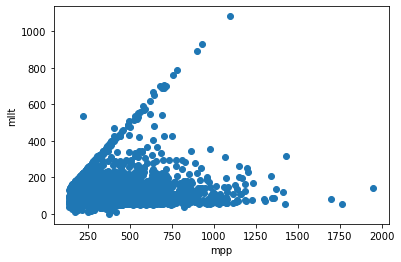

<Figure size 432x288 with 0 Axes>

In [141]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

plt.scatter(mpp, mllt)
plt.xlabel("mpp")
plt.ylabel("mllt")
plt.show()
plt.savefig('InvariantMassCorrXiCriteria.png')

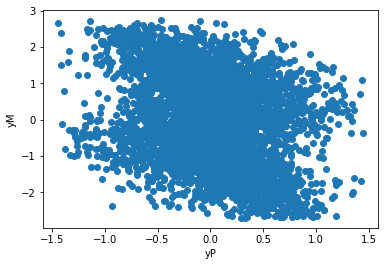

<Figure size 432x288 with 0 Axes>

In [142]:
np.random.seed(19680801)

plt.scatter(yP, ylt)
plt.xlabel("yP")
plt.ylabel("yM")
plt.show()
plt.savefig('RapidityCorrXiCriteria.png')

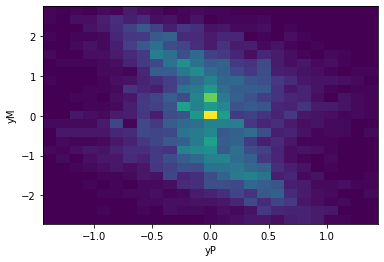

In [143]:
plt.hist2d(yP, ylt, bins=25)
plt.xlabel("yP")
plt.ylabel("yM")
plt.show()

In [144]:
import matplotlib.pyplot as plt
import mplhep as hep
from matplotlib.colors import LogNorm

[Text(0.5, 24.0, 'DiffXi1'), Text(53.5, 0.5, 'number of entries')]

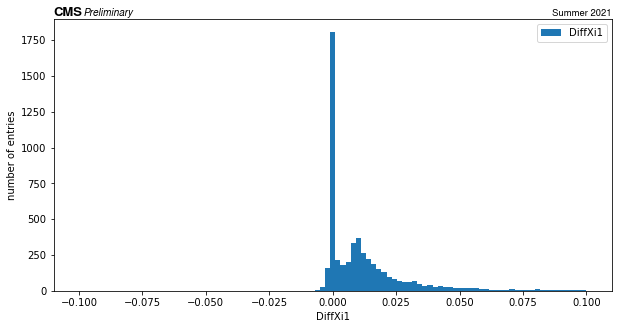

In [145]:
#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(diff1, bins=np.linspace(-0.1,0.1,100),label='DiffXi1')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel='DiffXi1', ylabel='number of entries')
#plt.savefig('number_muons_signal.png')

[Text(0.5, 24.0, 'DiffXi2'), Text(53.5, 0.5, 'number of entries')]

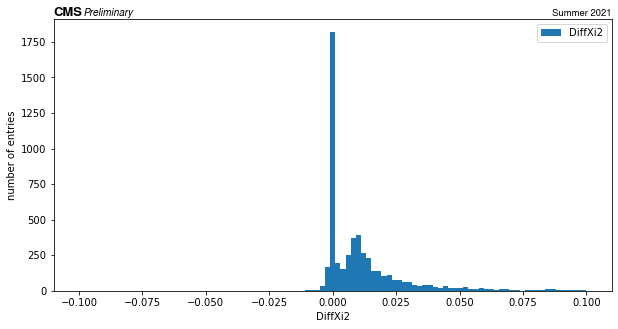

In [146]:
#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(diff2, bins=np.linspace(-0.1,0.1,100),label='DiffXi2')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel='DiffXi2', ylabel='number of entries')
#plt.savefig('number_muons_signal.png')
    

In [147]:
mppt=np.zeros(nevents)
mppt_sm=np.zeros(nevents)
diff1t=np.zeros(nevents)
diff2t=np.zeros(nevents)
diff1t_sm=np.zeros(nevents)
diff2t_sm=np.zeros(nevents)
PU1t=np.zeros(nevents)
PU2t=np.zeros(nevents)
PU1tsm=np.zeros(nevents)
PU2tsm=np.zeros(nevents)

xiMt=np.zeros(nevents)
ximt=np.zeros(nevents)
xiMt_sm=np.zeros(nevents)
ximt_sm=np.zeros(nevents)
tMt=np.zeros(nevents)
tmt=np.zeros(nevents)
tMt_sm=np.zeros(nevents)
tmt_sm=np.zeros(nevents)
difzT=np.zeros(nevents)-100
difzT_sm=np.zeros(nevents)-100
difzT1_sm=np.zeros(nevents)
difzT2_sm=np.zeros(nevents)
yPtsm=np.zeros(nevents)
yPt=np.zeros(nevents)
sumTs=np.zeros(nevents)

In [148]:
sumTsnsm=np.zeros(nevents)

In [149]:
NumDZT=0
c=30

for k in tqdm(range(nevents)):
    #print(k)
    if len(xiPairs[k])>0:
        xiMt[k]=xiPairs[k][0][0]
        ximt[k]=xiPairs[k][0][1]
        PU1t[k]=PU[k][0][0]
        PU2t[k]=PU[k][0][1]
        tMt[k]=tPairs[k][0][0]
        tmt[k]=tPairs[k][0][1]
        mppt[k]=14000.*np.sqrt(xiPairs[k][0][0]*xiPairs[k][0][1])
        diff1t[k]=xiPairs[k][0][0]-((sumET[k]+sumTPz[k])/14000)
        diff2t[k]=xiPairs[k][0][1]-((sumET[k]-sumTPz[k])/14000)
        difzT[k]=Tmu_z[k][0]-0.5*c*(tPairs[k][0][1]-tPairs[k][0][0])
        yPt[k]=-0.5*np.log(xiMt[k]/ximt[k])
        sumTsnsm[k]=(tMt[k]+tmt[k])*c-2*23400
        Dzt=[]
        for i in range (NP[k]):
            Dzt=((Tmu_z[k][0]-0.5*c*(tPairs[k][i][1]-tPairs[k][i][0])))
            #print(i,Tmu_z[k][0],0.5*c*(tPairs[k][i][1]-tPairs[k][i][0]))
            if Dzt**2 < (Tmu_z[k][0]-0.5*c*(tmt[k]-tMt[k]))**2:
                #print(k,i,Tmu_z[k][0],0.5*c*(tPairs[k][i][1]-tPairs[k][i][0]))
                PU1t[k]=PU[k][i][0]
                PU2t[k]=PU[k][i][1]
                xiMt[k]=xiPairs[k][i][0]
                ximt[k]=xiPairs[k][i][1]
                tMt[k]=tPairs[k][i][0]
                tmt[k]=tPairs[k][i][1]
                mppt[k]=14000.*np.sqrt(xiPairs[k][i][0]*xiPairs[k][i][1])
                diff1t[k]=xiPairs[k][i][0]-((sumET[k]+sumTPz[k])/14000)
                diff2t[k]=xiPairs[k][i][1]-((sumET[k]-sumTPz[k])/14000)
                difzT[k]=Tmu_z[k][0]-0.5*c*(tPairs[k][i][1]-tPairs[k][i][0])
                yPt[k]=-0.5*np.log(xiMt[k]/ximt[k])
                sumTsnsm[k]=(tMt[k]+tmt[k])*c-2*23400
                #print(k,Tmu_z[k][0])
                
    if difzT[k]==0:
        NumDZT=NumDZT+1
                #print(i,0.5*c*(tPairs[k][i][1]-tPairs[k][i][0]))

100%|██████████| 5272/5272 [00:19<00:00, 264.56it/s]


In [150]:
NumDZT_sm=0
NumST_sm=0
c=30

for k in tqdm(range(nevents)):
    #print(k)
    if len(xiPairs[k])>0:
        xiMt_sm[k]=xiPairs[k][0][0]
        ximt_sm[k]=xiPairs[k][0][1]
        PU1tsm[k]=PU[k][0][0]
        PU2tsm[k]=PU[k][0][1]
        tMt_sm[k]=t_smPairs[k][0][0]
        tmt_sm[k]=t_smPairs[k][0][1]
        mppt_sm[k]=14000.*np.sqrt(xiPairs[k][0][0]*xiPairs[k][0][1])
        diff1t_sm[k]=xiPairs[k][0][0]-((sumET[k]+sumTPz[k])/14000)
        diff2t_sm[k]=xiPairs[k][0][1]-((sumET[k]-sumTPz[k])/14000)
        difzT_sm[k]=Tmu_z[k][0]-0.5*c*(t_smPairs[k][0][1]-t_smPairs[k][0][0])   
        Dzt=[]
        yPtsm[k]=-0.5*np.log(xiMt_sm[k]/ximt_sm[k])        
        sumTs[k]=(tMt_sm[k]+tmt_sm[k])*c-2*23400
        
        for i in range (NP[k]):
            Dzt=((Tmu_z[k][0]-0.5*c*(t_smPairs[k][i][1]-t_smPairs[k][i][0])))
            #print(i,Tmu_z[k][0],0.5*c*(tPairs[k][i][1]-tPairs[k][i][0]))
            if Dzt**2 < (Tmu_z[k][0]-0.5*c*(tmt_sm[k]-tMt_sm[k]))**2:
                #print(k,i,Tmu_z[k][0],0.5*c*(tPairs[k][i][1]-tPairs[k][i][0]))
                xiMt_sm[k]=xiPairs[k][i][0]
                ximt_sm[k]=xiPairs[k][i][1]
                PU1tsm[k]=PU[k][0][0]
                PU2tsm[k]=PU[k][0][1]
                tMt_sm[k]=t_smPairs[k][i][0]
                tmt_sm[k]=t_smPairs[k][i][1]
                mppt_sm[k]=14000.*np.sqrt(xiPairs[k][i][0]*xiPairs[k][i][1])
                diff1t_sm[k]=xiPairs[k][i][0]-((sumET[k]+sumTPz[k])/14000)
                diff2t_sm[k]=xiPairs[k][i][1]-((sumET[k]-sumTPz[k])/14000)
                
                yPtsm[k]=-0.5*np.log(xiMt_sm[k]/ximt_sm[k])
                
                sumTs[k]=(tMt_sm[k]+tmt_sm[k])*c-2*23400
#                difzT1_sm[k]=Tmu_T[k][0]-(t_smPairs[k][i][0]-(23400-Tmu_z[k][0])/c)
#                difzT2_sm[k]=Tmu_T[k][0]-(t_smPairs[k][i][1]-(23400-Tmu_z[k][0])/c)                
                difzT_sm[k]=Tmu_z[k][0]-0.5*c*(t_smPairs[k][i][1]-t_smPairs[k][i][0])
                #print(k,Tmu_z[k][0])
                
    if difzT_sm[k]==0:
        NumDZT_sm=NumDZT_sm+1
        
    if sumTs[k]==0:
        NumST_sm=NumST_sm+1
                #print(i,0.5*c*(tPairs[k][i][1]-tPairs[k][i][0]))

100%|██████████| 5272/5272 [00:19<00:00, 265.25it/s]


In [151]:
len(xiMt)
print(NumDZT)
print(NumDZT_sm)
print(NumST_sm)

20
0
0


[Text(0.5, 24.0, 'DiffzT'), Text(59.875, 0.5, 'number of entries')]

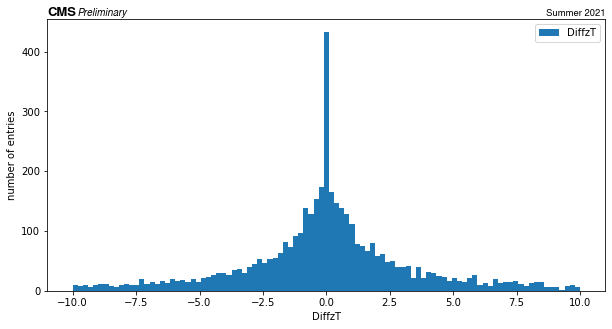

In [152]:
#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(difzT, bins=np.linspace(-10,10,100),label='DiffzT')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel='DiffzT', ylabel='number of entries')
#plt.savefig('VtxZ-TimeDiff XiSmear.png')

[Text(0.5, 24.0, 'DiffzT_tsmear'), Text(59.875, 0.5, 'number of entries')]

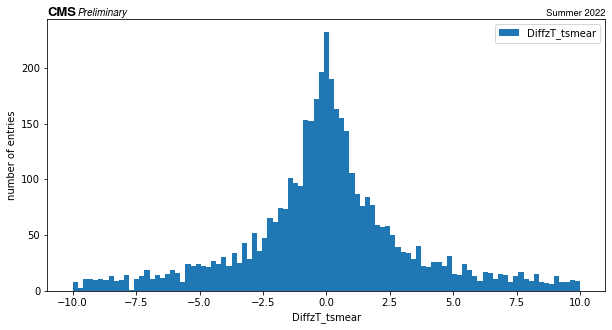

In [153]:
#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(difzT_sm, bins=np.linspace(-10,10,100),label='DiffzT_tsmear')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=ax)
ax.legend(); 
ax.set(xlabel='DiffzT_tsmear', ylabel='number of entries')
#plt.savefig('VtxZ-TimeDiff Xi&TSmear.png')

In [154]:
sig=[]
bk=[]
for i in range (len(difzT_sm)):
    if (PU1tsm[i]+PU2tsm[i]==0):
        sig.append(difzT_sm[i])
    else:
        bk.append(difzT_sm[i])

In [155]:
len(sig)

265

[Text(0.5, 24.0, 'DiffT'), Text(59.875, 0.5, 'number of entries')]

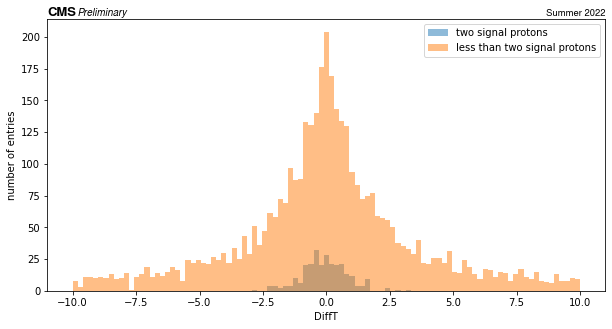

In [156]:


#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(sig, bins=np.linspace(-10,10,100), alpha=0.5 ,label='two signal protons')
plt.hist(bk, bins=np.linspace(-10,10,100), alpha=0.5 ,label='less than two signal protons')

hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=ax)
ax.legend(); 
ax.set(xlabel='DiffT', ylabel='number of entries')
#plt.savefig('InvariantMassCorrBothSmearing.png')

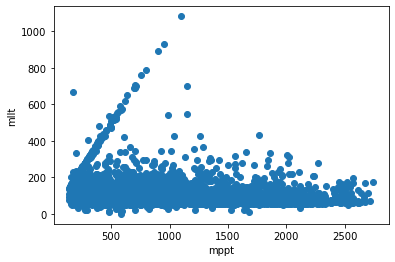

In [157]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

plt.scatter(mppt, mllt)
plt.xlabel("mppt")
plt.ylabel("mllt")
plt.show()

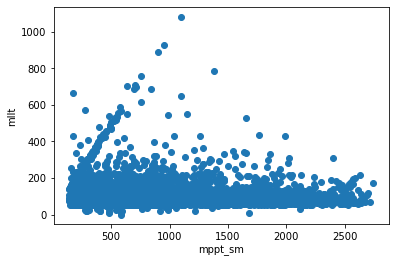

In [158]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

plt.scatter(mppt_sm, mllt)
plt.xlabel("mppt_sm")
plt.ylabel("mllt")
plt.show()

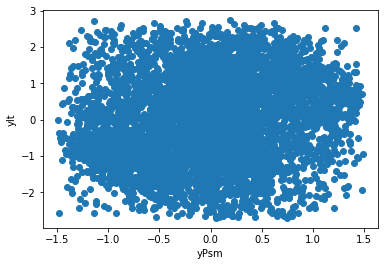

In [159]:
# Fixing random state for reproducibility
np.random.seed(19680801)

plt.scatter(yPtsm, ylt)
plt.xlabel("yPsm")
plt.ylabel("ylt")
plt.show()

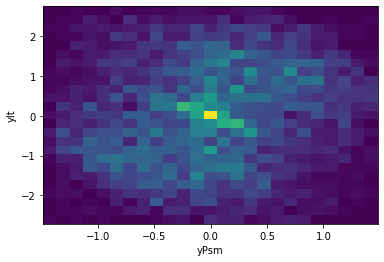

In [160]:
plt.hist2d(yPtsm, ylt, bins=25)
plt.xlabel("yPsm")
plt.ylabel("ylt")
plt.show()

In [161]:
print(xiM)
print(xim)
print(xiMt)
print(ximt)

[0.02021257 0.01434835 0.02817084 ... 0.03709268 0.01100305 0.01656922]
[0.01182137 0.01131961 0.03085873 ... 0.01243761 0.06481395 0.01539193]
[0.02021257 0.01434835 0.13278395 ... 0.12402555 0.01744411 0.01656922]
[0.12227968 0.01081518 0.06874511 ... 0.01627625 0.16990605 0.01539193]


In [162]:
print(len(xiM))
print(len(xiMt))

5272
5272


In [163]:
XIM=np.zeros(nevents)
XIm=np.zeros(nevents)
TMt=np.zeros(nevents)
Tmt=np.zeros(nevents)
PUP1=np.zeros(nevents)
PUP2=np.zeros(nevents)

numnz=0
XIMnsm=np.zeros(nevents)
XImnsm=np.zeros(nevents)
numnznsm=0

In [164]:
TMtnsm=np.zeros(nevents)
Tmtnsm=np.zeros(nevents)

In [165]:
for i in tqdm(range(nevents)):
    #print(k)
    if xiM[i]==xiMt_sm[i] and xim[i]==ximt_sm[i]:
        XIM[i]=xiM[i]
        XIm[i]=xim[i]
        TMt[i]=tMt_sm[i]
        Tmt[i]=tmt_sm[i]
        PUP1[i]=PU1[i]
        PUP2[i]=PU2[i]
        numnz=numnz+1

100%|██████████| 5272/5272 [00:00<00:00, 1457926.46it/s]


In [166]:
for i in tqdm(range(nevents)):
    #print(k)
    if xiM[i]==xiMt[i] and xim[i]==ximt[i]:
        XIMnsm[i]=xiM[i]
        XImnsm[i]=xim[i]
        TMtnsm[i]=tMt[i]
        Tmtnsm[i]=tmt[i]
        numnznsm=numnznsm+1

100%|██████████| 5272/5272 [00:00<00:00, 1515168.61it/s]


In [167]:
print(XIM[0:20])
print(numnz)
print(XIMnsm[0:20])
print(numnznsm)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.03715353 0.01850273 0.         0.12074076
 0.         0.07988519 0.         0.         0.         0.
 0.         0.        ]
670
[0.         0.         0.         0.         0.         0.
 0.         0.         0.03715353 0.01850273 0.         0.12074076
 0.         0.07988519 0.         0.         0.         0.
 0.         0.        ]
715


In [168]:
MPP=[]
MLL=[]
M=[]
YPP=[]
YLL=[]
Y=[]
CTDif=[]
Muz=[]
Mut=[]
ST=[]
SP=[]

for i in range (nevents):
    if (XIM[i]!=0) and (TMu2_pt[i]>0):
        MPP.append(14000.*np.sqrt(XIM[i]*XIm[i]))
        MLL.append(mllt[i])
        YPP.append(0.5*np.log(XIM[i]/XIm[i]))
        YLL.append(ylt[i])
        CTDif.append(0.5*c*(TMt[i]-Tmt[i]))
        Muz.append(Tmu_z[i][0])
        Mut.append(Tmu_T[i][0])
        ST.append((0.5*sumTs[i])/c)
        SP.append(PUP1[i]+PUP2[i])
    
print(len(MPP)/10000)
for i in range (len(MPP)):
    M.append((MPP[i]-MLL[i])/(MPP[i]+MLL[i]))
    Y.append((YPP[i]-YLL[i])) #/(YPP[i]+YLL[i]))


MPPnsm=[]
MLLnsm=[]
Mnsm=[]
YPPnsm=[]
YLLnsm=[]
Ynsm=[]
CTDifnsm=[]
Muznsm=[]
Mutnsm=[]
STnsm=[]
for i in range (nevents):
    if (XIMnsm[i]!=0) and (TMu2_pt[i]>0):
        MPPnsm.append(14000.*np.sqrt(XIMnsm[i]*XImnsm[i]))
        MLLnsm.append(mllt[i])
        CTDifnsm.append(0.5*c*(TMtnsm[i]-Tmtnsm[i]))
        Muznsm.append(Tmu_z[i][0])
        Mutnsm.append(Tmu_T[i][0])
        STnsm.append((0.5*sumTsnsm[i])/c)
print(len(MPPnsm)/10000)
for i in range (len(MPPnsm)):
    Mnsm.append((MPPnsm[i]-MLLnsm[i])/(MPPnsm[i]+MLLnsm[i]))



0.067
0.0715


In [169]:
print(sumTs[0:500])

[-9.85685902e+01  1.96449793e+01 -5.94683373e+01  1.59454474e+02
  1.54240495e+02  3.74945526e+01 -2.29610170e+01 -1.62867708e+02
  1.49436777e+01  6.16459022e-01  3.74170837e+01  1.60106934e+01
  1.30079449e+02 -9.88298121e+01 -1.55000951e+01  3.75889657e+01
 -1.31114846e+02 -5.27018618e+01 -1.81957707e+02 -1.19756450e+02
 -1.08194603e+01 -8.27326746e+01 -3.48911958e+00 -3.03582383e+01
  1.02805931e+01  3.67279575e-01 -2.84832864e+01  1.00986193e+02
  2.62696154e+00 -9.36931650e+00  5.24913798e+00  6.08132304e+01
 -7.02325781e+01  2.37414669e+01 -4.90775721e+00 -4.47684520e+01
 -4.84588344e+00 -3.14789037e+01 -5.35815106e+01 -1.03119160e+02
 -5.52712130e+01 -4.18843903e+00  1.67728726e+01 -5.37932655e+00
 -7.51449213e+01  2.40944520e+01 -7.30032178e+01  9.92400403e+01
  2.72770661e+01  6.01872101e-01 -1.90221684e+01 -4.96660387e+01
 -3.27136074e+00  2.65397343e+01 -6.25417307e-01 -7.84365800e+01
 -3.52266933e+01  6.35338787e+00 -1.05441469e+02 -9.46511705e+01
 -1.29827239e+01 -6.48438

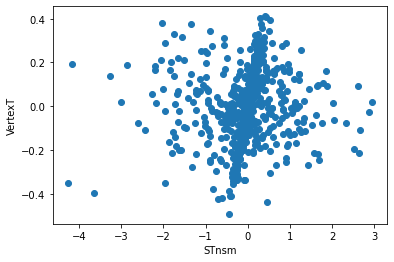

In [170]:
np.random.seed(19680801)

plt.scatter(STnsm,Mutnsm)
plt.xlabel("STnsm")
plt.ylabel("VertexT")
plt.show()

In [171]:
len(MLL)

670

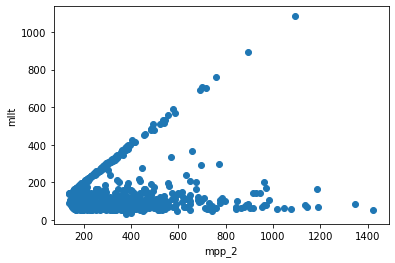

In [172]:
import matplotlib.pyplot as plt 
import numpy as np


plt.scatter(MPP,MLL)
plt.xlabel("mpp_2")
plt.ylabel("mllt")
plt.show()

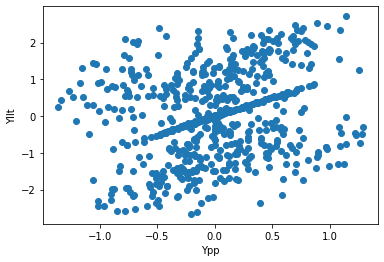

In [173]:
np.random.seed(19680801)

plt.scatter(YPP,YLL)
plt.xlabel("Ypp")
plt.ylabel("Yllt")
plt.show()

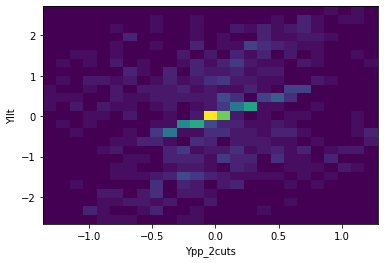

In [174]:
plt.hist2d(YPP, YLL, bins=25)
plt.xlabel("Ypp_2cuts")
plt.ylabel("Yllt")
plt.show()

No handles with labels found to put in legend.


[Text(0.5, 24.0, 'Y'), Text(66.25, 0.5, 'number of entries')]

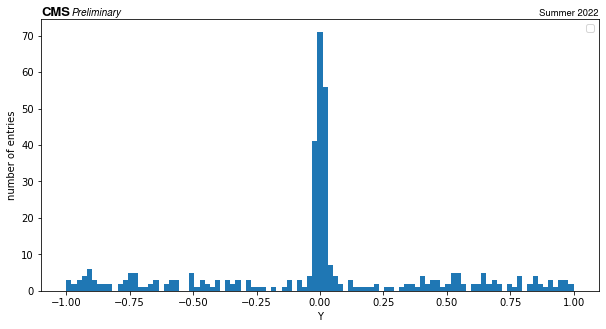

In [175]:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(Y, bins=np.linspace(-1,1,100))
hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=ax)
ax.legend(); 
ax.set(xlabel='Y', ylabel='number of entries')

[Text(0.5, 33.0, 'Ypp-Yll'), Text(66.25, 0.5, 'number of entries')]

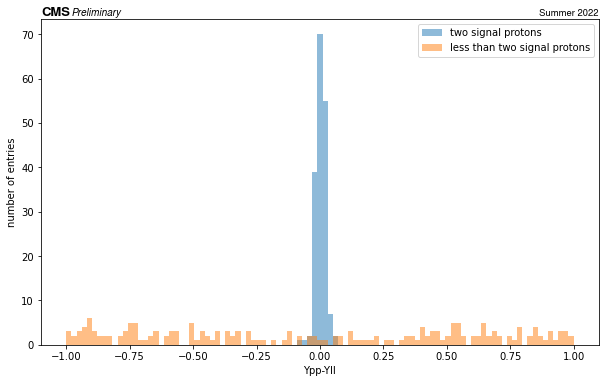

In [176]:
sigY=[]
bkY=[]
for i in range (len(Y)):
    if (SP[i]==0):
        sigY.append(Y[i])
    else:
        bkY.append(Y[i])

#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,6))
plt.hist(sigY, bins=np.linspace(-1,1,100), alpha=0.5 ,label='two signal protons')
plt.hist(bkY, bins=np.linspace(-1,1,100), alpha=0.5 ,label='less than two signal protons')

hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=ax)
ax.legend(); 
ax.set(xlabel='Ypp-Yll', ylabel='number of entries')
#plt.savefig('InvariantMassCorrBothSmearing.png')

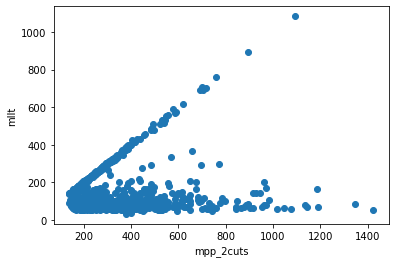

In [177]:
import matplotlib.pyplot as plt
import numpy as np

#Un Smeared
np.random.seed(19680801)

plt.scatter(MPPnsm,MLLnsm)
plt.xlabel("mpp_2cuts")
plt.ylabel("mllt")
plt.show()

[Text(0.5, 24.0, 'MPP-MLL'), Text(59.875, 0.5, 'number of entries')]

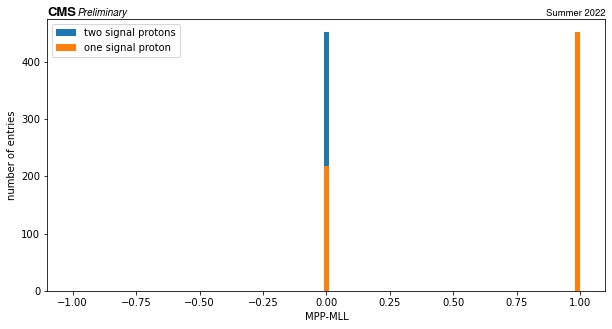

In [178]:
#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,5))
plt.hist([m<0.25 for m in M], bins=np.linspace(-1,1,100),label='two signal protons')
plt.hist([m>0.25 for m in M], bins=np.linspace(-1,1,100),label='one signal proton')

hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=ax)
ax.legend(); 
ax.set(xlabel='MPP-MLL', ylabel='number of entries')
#plt.savefig('InvariantMassCorrBothSmearing.png')

[Text(0.5, 24.0, 'MPP-MLL'), Text(59.875, 0.5, 'number of entries')]

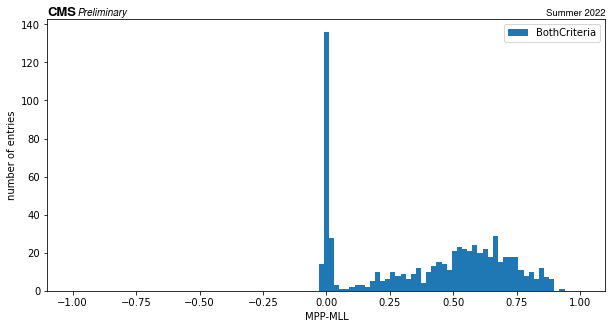

In [179]:
#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(M, bins=np.linspace(-1,1,100),label='BothCriteria')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=ax)
ax.legend(); 
ax.set(xlabel='MPP-MLL', ylabel='number of entries')
#plt.savefig('InvariantMassCorrXiSmearings.png')

[Text(0.5, 33.0, 'Mpp-Mll'), Text(59.875, 0.5, 'number of entries')]

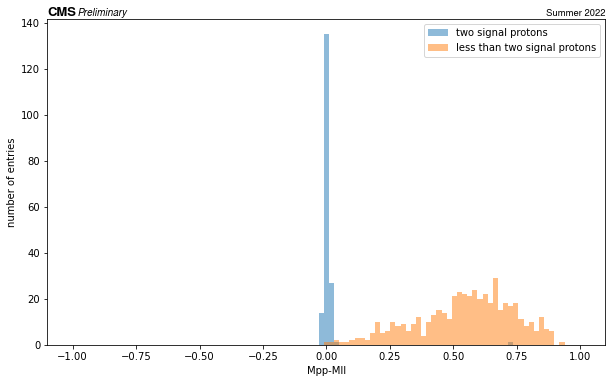

In [180]:
sigM=[]
bkM=[]
for i in range (len(M)):
    if (SP[i]==0):
        sigM.append(M[i])
    else:
        bkM.append(M[i])

#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,6))
plt.hist(sigM, bins=np.linspace(-1,1,100), alpha=0.5 ,label='two signal protons')
plt.hist(bkM, bins=np.linspace(-1,1,100), alpha=0.5 ,label='less than two signal protons')

hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=ax)
ax.legend(); 
ax.set(xlabel='Mpp-Mll', ylabel='number of entries')
#plt.savefig('InvariantMassCorrBothSmearing.png')

In [181]:
len(M)

670

In [182]:
s=0

for i in range (len(M)):
    if SP[i]==0:
        s=s+1
print(s)



178


In [183]:
ktnsm=0
for i in range (len(Mnsm)):
    if np.abs(Mnsm[i])<0.025:
        ktnsm=ktnsm+1
print(ktnsm)
Lum=300e15
Cross=0.2735e-12
Accnsm=ktnsm/10000
NumbEvnsm=Lum*Cross*Accnsm
print(NumbEvnsm)

234
1919.97


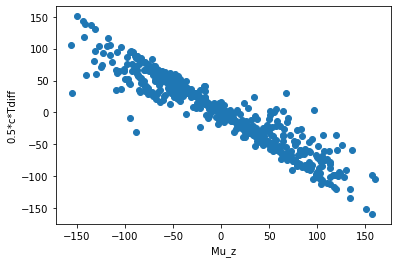

In [184]:
np.random.seed(19680801)

plt.scatter(Muz,CTDif)
plt.xlabel("Mu_z")
plt.ylabel("0.5*c*Tdiff")
plt.show()

In [185]:
#Clean the events
#Plot with density


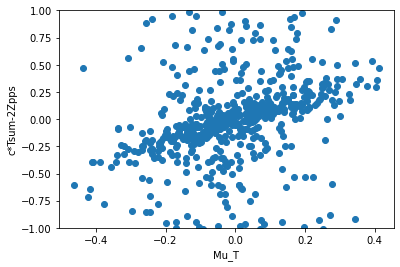

In [186]:
np.random.seed(19680801)

plt.scatter(Mut,ST)
plt.xlabel("Mu_T")
plt.ylabel("c*Tsum-2Zpps")
plt.ylim([-1,1])
plt.show()

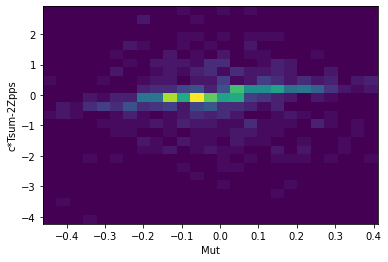

In [187]:
plt.hist2d(Mut, ST, bins=25)
plt.xlabel("Mut")
plt.ylabel("c*Tsum-2Zpps")
plt.show()

In [188]:
D=np.zeros(len(Mut))
DD=np.zeros(len(Mut))

for ev in range(len(Mut)):

    D[ev]=Mut[ev]-ST[ev]
    DD[ev]=Muz[ev]+CTDif[ev]

[Text(0.5, 33.0, 'Vertex Z difference'), Text(66.25, 0.5, 'number of entries')]

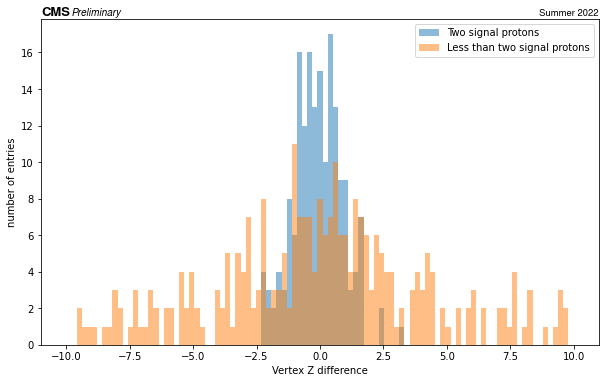

In [189]:
sigT=[]
bkT=[]
for i in range (len(Muz)):
    if (SP[i]==0):
        sigT.append(Muz[i]+CTDif[i])
    else:
        bkT.append(Muz[i]+CTDif[i])

#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,6))
plt.hist(sigT, bins=np.linspace(-10,10,100), alpha=0.5 ,label='Two signal protons')
plt.hist(bkT, bins=np.linspace(-10,10,100), alpha=0.5 ,label='Less than two signal protons')

hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=ax)
ax.legend(); 
ax.set(xlabel='Vertex Z difference', ylabel='number of entries')
#plt.savefig('InvariantMassCorrBothSmearing.png')

No handles with labels found to put in legend.


[Text(0.5, 24.0, 'DD'), Text(66.25, 0.5, 'number of entries')]

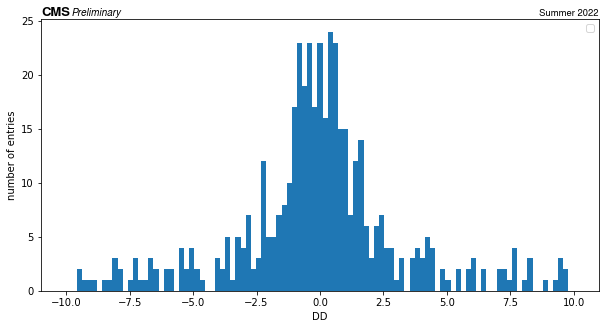

In [190]:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(DD, bins=np.linspace(-10,10,100),label='')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=ax)
ax.legend(); 
ax.set(xlabel='DD', ylabel='number of entries')
#plt.savefig('InvariantMassCorrBothSmearings.png')

In [191]:
len(DD)

670

No handles with labels found to put in legend.


[Text(0.5, 24.0, 'D'), Text(66.25, 0.5, 'number of entries')]

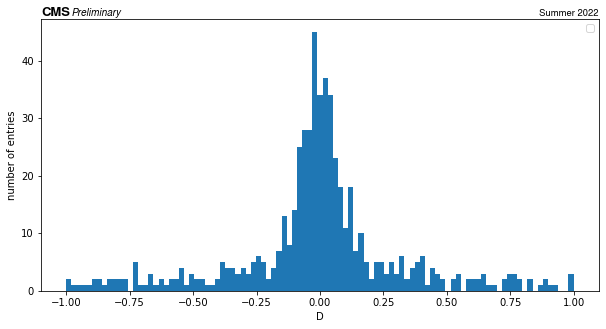

In [192]:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(D, bins=np.linspace(-1,1,100),label='')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=ax)
ax.legend(); 
ax.set(xlabel='D', ylabel='number of entries')
#plt.savefig('InvariantMassCorrBothSmearings.png')

[Text(0.5, 33.0, 'Vertex time difference'),
 Text(66.25, 0.5, 'number of entries')]

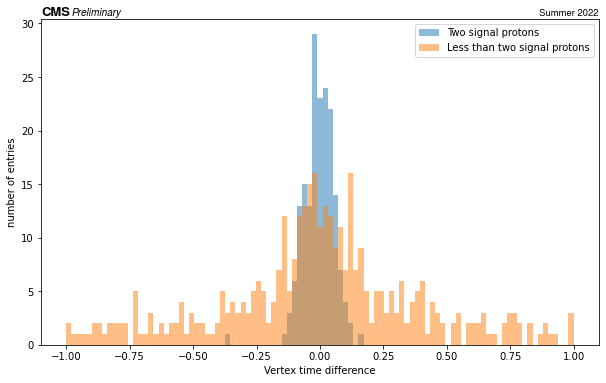

In [193]:
sigD=[]
bkD=[]
for i in range (len(D)):
    if (SP[i]==0):
        sigD.append(D[i])
    else:
        bkD.append(D[i])

#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,6))
plt.hist(sigD, bins=np.linspace(-1,1,100), alpha=0.5 ,label='Two signal protons')
plt.hist(bkD, bins=np.linspace(-1,1,100), alpha=0.5 ,label='Less than two signal protons')

hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=ax)
ax.legend(); 
ax.set(xlabel='Vertex time difference', ylabel='number of entries')
#plt.savefig('InvariantMassCorrBothSmearing.png')

In [194]:
len(sigD)+len(bkD)

670

In [195]:
ktM=0
for i in range (len(M)):
    if (np.abs(M[i])<0.025):
        ktM=ktM+1
print(ktM)
Lum=300e15
Cross=0.2735e-12
Acc=ktM/n_events
NumbEvM=Lum*Cross*Acc
print(NumbEvM)

177
1452.285


In [196]:
ktY=0
for i in range (len(Y)):
    if (np.abs(Y[i])<0.05):
        ktY=ktY+1
print(ktY)
Lum=300e15
Cross=0.2735e-12
Acc=ktY/n_events
NumbEvY=Lum*Cross*Acc
print(NumbEvY)

179
1468.695


In [197]:
ktD=0
for i in range (len(D)):
    if (np.abs(D[i])<0.25):
        ktD=ktD+1
print(ktD)
Lum=300e15
Cross=0.2735e-12
Acc=ktD/n_events
NumbEvD=Lum*Cross*Acc
print(NumbEvD)

393
3224.565


In [198]:
ktDD=0
for i in range (len(DD)):
    if (np.abs(DD[i])<1.5):
        ktDD=ktDD+1
print(ktM)
Lum=300e15
Cross=0.2735e-12
Acc=ktDD/n_events
NumbEvM=Lum*Cross*Acc
print(NumbEvM)

177
2051.25


In [199]:
kts=0
for i in range (len(M)):
    if (np.abs(M[i])<0.025) and (np.abs(Y[i])<0.05):
        kts=kts+1
print(kts)
Lum=300e15
Cross=0.2735e-12
Acc=kts/n_events
NumbEv=Lum*Cross*Acc
print(NumbEv)

173
1419.465


In [200]:
kts=0
for i in range (len(M)):
    if (np.abs(M[i])<0.025) and (np.abs(D[i])<0.25):
        kts=kts+1
print(kts)
Lum=300e15
Cross=0.2735e-12
Acc=kts/n_events
NumbEv=Lum*Cross*Acc
print(NumbEv)

175
1435.8750000000002


In [201]:
kts=0
for i in range (len(M)):
    if (np.abs(Y[i])<0.05) and (np.abs(D[i])<0.25):
        kts=kts+1
print(kts)
Lum=300e15
Cross=0.2735e-12
Acc=kts/n_events
NumbEv=Lum*Cross*Acc
print(NumbEv)

174
1427.6699999999998


In [202]:
kts=0
for i in range (len(M)):
    if (np.abs(M[i])<0.025) and (np.abs(Y[i])<0.05) and (np.abs(D[i])<0.25):
        kts=kts+1
print(kts)
Lum=300e15
Cross=0.2735e-12
Acc=kts/n_events
NumbEv=Lum*Cross*Acc
print(NumbEv)

171
1403.055


In [203]:
kts=0
for i in range (len(M)):
    if (np.abs(M[i])<0.025) and (np.abs(Y[i])<0.05) and (np.abs(D[i])<0.25) and (np.abs(DD[i])<1.5):
        kts=kts+1
print(kts)
Lum=300e15
Cross=0.2735e-12
Acc=kts/n_events
NumbEv=Lum*Cross*Acc
print(NumbEv)

147
1206.135


In [204]:
sumpu=0
for i in range(len(M)):
    if (SP[i]==0):
        sumpu=sumpu+1
print(sumpu/len(M))

0.2656716417910448


In [205]:
sumpu2=0
for i in range(len(M)):
    if (SP[i]==0) and (np.abs(M[i])<0.025) and (np.abs(Y[i])<0.05) and (np.abs(D[i])<0.25):
        sumpu2=sumpu2+1
print(sumpu2/s)

0.9550561797752809


In [206]:
#(tMt_sm[k]+tmt_sm[k])*c-2*23400

In [207]:
#            t[k]=(genproton_t[i][k]+(23400-genproton_vz[i][k])/30) 

#        else: 
#            t[k]=(genproton_t[i][k]+(23400+genproton_vz[i][k])/30) 

In [208]:
sumpu2/s

0.9550561797752809

In [209]:
#See the Difft cut (using the signal protons)
#Add the luminonsity & cross section to the numbers of the cuts
#
#
#
#